# Введение #

В мире глубокого обучения есть не только полносвязные (dense) слои. Есть десятки типов слоев, которые можно добавить в модель. (Для примера загляните в [документацию Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/)!) Некоторые слои похожи на dense и задают связи между нейронами, а другие выполняют предобработку или иные преобразования.

В этом уроке мы познакомимся с двумя видами специальных слоев, которые сами не содержат нейронов, но добавляют функциональность, которая иногда полезна модели. Оба широко используются в современных архитектурах.

# Dropout #

Первый из них - "слой dropout", который помогает бороться с переобучением.

В прошлом уроке мы говорили, что переобучение возникает из-за того, что сеть учится случайным, ложным закономерностям в обучающих данных. Чтобы распознавать такие закономерности, сеть часто опирается на очень конкретные сочетания весов - своего рода "сговор" весов. Из-за своей специфичности они хрупкие: убери один - и весь "сговор" распадается.

В этом и состоит идея **dropout**. Чтобы разрушать такие "сговоры", на каждом шаге обучения мы случайно *отключаем* некоторую долю входных нейронов слоя, что делает обучение на ложных закономерностях гораздо сложнее. Вместо этого сеть вынуждена искать более широкие, общие паттерны, чьи наборы весов обычно более устойчивы.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/a86utxY.gif" width="600" alt="Анимация сети, перебирающей разные случайные конфигурации dropout.">
<figcaption style="textalign: center; font-style: italic"><center>Здесь между двумя скрытыми слоями добавлен dropout 50%.</center></figcaption>
</figure>

Также можно думать о dropout как о создании *ансамбля* сетей. Предсказания делает уже не одна большая сеть, а комитет меньших сетей. Участники комитета склонны ошибаться по-разному, но часто оказываются правы одновременно, поэтому комитет в целом лучше любого отдельного участника. (Если вы знакомы со случайными лесами как ансамблем деревьев решений, это та же идея.)

## Добавление Dropout ##

В Keras аргумент `rate` задает, какой процент входных нейронов отключать. Слой `Dropout` ставится непосредственно перед слоем, к которому применяется dropout:

```
keras.Sequential([
    # ...
    layers.Dropout(rate=0.3), # применить 30% dropout к следующему слою
    layers.Dense(16),
    # ...
])
```

# Batch Normalization #

Следующий специальный слой - "нормализация по батчу" (batch normalization, или batchnorm). Она помогает исправлять медленное или нестабильное обучение.

Для нейронных сетей обычно полезно привести все данные к общему масштабу, например с помощью [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) или [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) из scikit-learn. Причина в том, что SGD сдвигает веса пропорционально величине активаций, которые порождают данные. Признаки, дающие активации очень разного масштаба, могут приводить к нестабильному обучению.

Если полезно нормализовать данные перед подачей в сеть, то, возможно, еще лучше нормализовать и внутри сети. Для этого есть специальный слой - **batch normalization**. Такой слой смотрит на каждый батч по мере поступления, сначала нормализует батч по его собственному среднему и стандартному отклонению, а затем переводит данные на новый масштаб с помощью двух обучаемых параметров. По сути, batchnorm выполняет согласованное масштабирование своих входов.

Чаще всего batchnorm добавляют как помощь оптимизации (хотя иногда он улучшает и качество предсказаний). Моделям с batchnorm обычно нужно меньше эпох обучения. Кроме того, batchnorm может исправлять разные проблемы, из-за которых обучение "застревает". Подумайте о добавлении batch normalization в ваши модели, особенно если возникают сложности при обучении.

## Добавление Batch Normalization ##

Похоже, batch normalization можно применять почти в любой точке сети. Можно поставить его после слоя...

```
layers.Dense(16, activation='relu'),
layers.BatchNormalization(),
```

... или между слоем и его функцией активации:

```
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),
```

А если добавить его первым слоем сети, он сможет работать как адаптивный препроцессор, заменяя что-то вроде `StandardScaler` из Sci-Kit Learn.

# Пример - Dropout и Batch Normalization #

Продолжим развивать модель *Red Wine*. Теперь мы еще увеличим емкость, но добавим dropout для контроля переобучения и batch normalization для ускорения оптимизации. В этот раз мы также не будем стандартизировать данные, чтобы показать, как batch normalization может стабилизировать обучение.


In [2]:
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


import pandas as pd
red_wine = pd.read_csv('../dataset/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

При добавлении dropout может потребоваться увеличить число нейронов в слоях `Dense`.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


В этот раз в настройке обучения ничего менять не нужно.


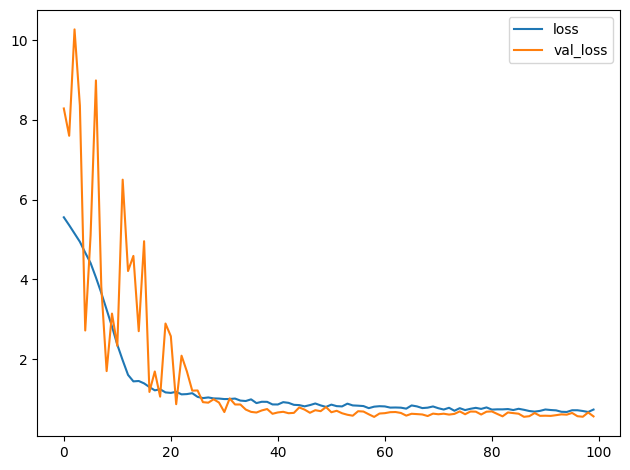

In [4]:
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

Обычно вы получите лучшую производительность, если стандартизируете данные перед обучением. То, что мы вообще смогли использовать сырые данные, показывает, насколько эффективной может быть batch normalization на более сложных датасетах.

# Ваш ход #

Переходите к [**улучшению предсказаний**](https://www.kaggle.com/kernels/fork/11887342) на датасете *Spotify* с dropout и посмотрите, как batch normalization помогает на сложных наборах данных.


---




*Есть вопросы или комментарии? Зайдите на [форум обсуждения курса](https://www.kaggle.com/learn/intro-to-deep-learning/discussion), чтобы пообщаться с другими учащимися.*
